# 1. Library installation

In [ ]:
!pip install tensorflow==2.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pytorch-pretrained-bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install bi-lstm-crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import keras
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torchvision.models as models


from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tqdm import tqdm, trange
from bi_lstm_crf.app.preprocessing import *
from bi_lstm_crf.app.utils import *

from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#2. Set Training Parameters


In [ ]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 64  # Number of examples used in each iteration
    EPOCHS = 20  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector

# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 10
    MAX_LEN = 75
    EMBEDDING = 20

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


#3. Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# data = pd.read_csv("gdrive/MyDrive/AI_project/ner_dataset.csv", encoding="latin1")
# data = data.fillna(method="ffill")
data= pd.read_csv("https://raw.githubusercontent.com/0wuxinyun/NER_AI_Project/main/ner_dataset.csv",encoding="latin1")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of tags: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10) 

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['I-eve', 'B-tim', 'B-per', 'B-nat', 'O', 'I-per', 'I-tim', 'B-eve', 'I-geo', 'B-org', 'B-art', 'B-geo', 'I-art', 'I-nat', 'I-gpe', 'I-org', 'B-gpe']
Number of tags:  17
What the dataset looks like:


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = SentenceGetter(data)
word_sent = [" ".join([s[0] for s in sent]) for sent in getter.sentences] 
print(word_sent[0]) # sentence str (w)
tag_sent = [[s[2] for s in sent] for sent in getter.sentences]
print(tag_sent[0]) # label of sentence (tag)

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


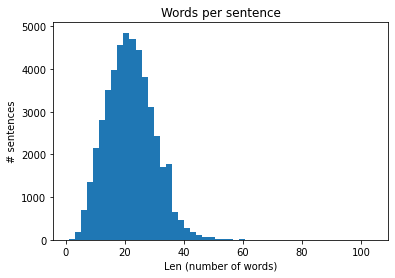

In [ ]:
sentences = getter.sentences

# Plot sentence by length
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Words per sentence')
plt.xlabel('Len (number of words)')
plt.ylabel('# sentences')
plt.show()

# 4. Bi-LSTM model

### 4.1 Data Preprocessing

In [ ]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding
idx2word = {i: w for w, i in word2idx.items()}

tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

print("The word war is identified by the index: {}".format(word2idx["war"]))
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))

# convert word and tag to index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X =  pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)


X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=0.2)

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('After processing, sample:', X[0])

print("")
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, labels:', y[0])

The word war is identified by the index: 32454
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 12
Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
After processing, sample: [10479  1134  4668 34620  9202  3087 29449 21520 12645 14401 32454 31001
   867  6404 16682 14401 16103  1134 33245  4474 21814 21639  7972  9661
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]

Raw Label:  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
After processing, labels: [ 5  5  5  5  5  5 12  5  5  5  5  5 12  5  5  5  5  5 17  5  5  5  5  5
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [ ]:
np.save("/content/gdrive/My Drive/words.npy",words)
np.save("/content/gdrive/My Drive/idx2tag.npy",idx2tag)
np.save("/content/gdrive/My Drive/word2idx.npy",word2idx)

In [ ]:
X_tr = torch.from_numpy(X_tr)
y_tr = torch.from_numpy(y_tr)
print(X_tr.shape)
print(y_tr.shape)

train_dataset = TensorDataset(X_tr, y_tr)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

X_val = torch.from_numpy(X_val)
y_val = torch.from_numpy(y_val)
print(X_val.shape)
print(y_val.shape)

val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

X_te = torch.from_numpy(X_te)
y_te = torch.from_numpy(y_te)
print(X_te.shape)
print(y_te.shape)

test_dataset = TensorDataset(X_te, y_te)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([30693, 75])
torch.Size([30693, 75])
torch.Size([7674, 75])
torch.Size([7674, 75])
torch.Size([9592, 75])
torch.Size([9592, 75])


### 4.2 Model initialization


In [ ]:
class BiLSTMPOSTagger(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers, 
                 bidirectional, 
                 dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = 0)
        
        self.lstm_layer = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = n_layers, 
                            bidirectional = bidirectional,
                            dropout = dropout if n_layers > 1 else 0)
        
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
      
        output, (_, _) = self.lstm_layer(embedded)
        
        predictions = self.fc(output)
        
        return predictions # [sent len, batch size, output dim]

In [ ]:
INPUT_DIM = n_words+2
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = n_tags + 1
LSTM_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5

model = BiLSTMPOSTagger(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        LSTM_LAYERS, 
                        BIDIRECTIONAL, 
                        DROPOUT).to(device)

### 4.3 Training

In [ ]:
def categorical_accuracy(preds, y):
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != 0).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / y[non_pad_elements].shape[0]

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()

    for batch in iterator:
        text = batch[0].to(device)
        tags = batch[1].to(device)
        
        optimizer.zero_grad()
        
        predictions = model(text)
        
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1).type(torch.LongTensor).to(device)
        
        loss = criterion(predictions, tags)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += categorical_accuracy(predictions, tags)
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    for batch in iterator:
        text = batch[0].to(device)
        tags = batch[1].to(device)

        predictions = model(text)
        
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1).type(torch.LongTensor).to(device)
      
        epoch_loss += criterion(predictions, tags)
        epoch_acc += categorical_accuracy(predictions, tags)

    return epoch_loss/len(iterator),epoch_acc/len(iterator)
        
  # pretrained - generalize, if train and test are similar 

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = 0).to(device)

In [ ]:
N_EPOCHS = 15

best_valid_loss = float('inf')
train_loss_list = []
val_loss_list = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_dataset, optimizer, criterion)

    valid_loss, valid_acc = evaluate(model, val_dataset, criterion)
    train_loss_list.append(train_loss)
    val_loss_list.append(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        model_save_name = 'BiLSTM_model_weights.pth'
        path = F"/content/gdrive/My Drive/{model_save_name}" 
        torch.save(model, path)

    
    print("Epoch: " + str(epoch))
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 0
	Train Loss: 0.319 | Train Acc: 91.48%
	 Val. Loss: 0.175 |  Val. Acc: 94.88%
Epoch: 1
	Train Loss: 0.207 | Train Acc: 94.05%
	 Val. Loss: 0.149 |  Val. Acc: 95.59%
Epoch: 2
	Train Loss: 0.175 | Train Acc: 94.86%
	 Val. Loss: 0.139 |  Val. Acc: 95.83%
Epoch: 3
	Train Loss: 0.159 | Train Acc: 95.29%
	 Val. Loss: 0.133 |  Val. Acc: 96.09%
Epoch: 4
	Train Loss: 0.149 | Train Acc: 95.58%
	 Val. Loss: 0.129 |  Val. Acc: 96.11%
Epoch: 5
	Train Loss: 0.142 | Train Acc: 95.81%
	 Val. Loss: 0.126 |  Val. Acc: 96.31%
Epoch: 6
	Train Loss: 0.137 | Train Acc: 95.93%
	 Val. Loss: 0.125 |  Val. Acc: 96.33%
Epoch: 7
	Train Loss: 0.133 | Train Acc: 96.08%
	 Val. Loss: 0.124 |  Val. Acc: 96.33%
Epoch: 8
	Train Loss: 0.129 | Train Acc: 96.16%
	 Val. Loss: 0.123 |  Val. Acc: 96.42%
Epoch: 9
	Train Loss: 0.127 | Train Acc: 96.21%
	 Val. Loss: 0.122 |  Val. Acc: 96.48%
Epoch: 10
	Train Loss: 0.125 | Train Acc: 96.32%
	 Val. Loss: 0.120 |  Val. Acc: 96.50%
Epoch: 11
	Train Loss: 0.123 | Train Acc: 

In [ ]:
 val_loss_list


[tensor(0.1746, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1488, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1388, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1329, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1289, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1258, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1247, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1239, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1227, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1218, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1201, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1181, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1197, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1184, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1180, device='cuda:0', grad_fn=<DivBackward0>)]

In [ ]:
new_val_loss_list = torch.Tensor(val_loss_list)
new_val_loss_list = new_val_loss_list.cpu().numpy()

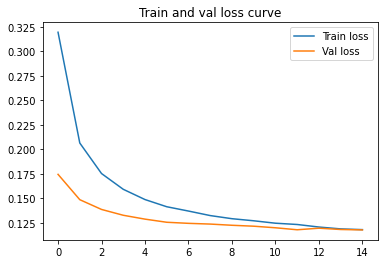

In [ ]:
import matplotlib.pyplot as plt
plt.title("Train and val loss curve")
plt.plot(range(15), train_loss_list, label='Train loss')
plt.plot(range(15), new_val_loss_list,  label='Val loss')
plt.legend()
plt.show()

### 4.4 Evaluation

In [ ]:
# Testing
test_loss = 0
test_acc = 0

model.eval()
pred = []
y_te_true = []

for batch in test_dataset:
    text = batch[0].to(device)
    tags = batch[1].to(device)

    predictions = model(text)
    
    predictions = predictions.view(-1, predictions.shape[-1])

    pred.append(np.argmax(predictions.detach().cpu().numpy(), axis=-1))
    y_te_true.append(tags.tolist())

    tags = tags.view(-1).type(torch.LongTensor).to(device)
    

    test_loss += criterion(predictions, tags)
    test_acc += categorical_accuracy(predictions, tags)

test_loss = test_loss/len(test_dataset)
test_acc = test_acc/len(test_dataset)

print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

	Test Loss: 0.114 | Test Acc: 96.58%


In [ ]:
from sklearn.metrics import classification_report

# Convert the index to tag
pred_tag = []
for row in pred:
  for i in row:
    pred_tag.append(idx2tag[i])

y_te_true_tag = []
for row in y_te_true:
  for i in row:
    y_te_true_tag.append(idx2tag[i])

report = classification_report(pred_tag, y_te_true_tag)
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00         0
       B-eve       0.36      0.02      0.04       861
       B-geo       0.89      0.81      0.85      8172
       B-gpe       0.91      0.97      0.94      2963
       B-nat       0.19      0.16      0.18        44
       B-org       0.70      0.74      0.72      3766
       B-per       0.80      0.80      0.80      3357
       B-tim       0.87      0.90      0.88      3981
       I-art       0.00      0.00      0.00       125
       I-eve       0.20      0.18      0.19        44
       I-geo       0.81      0.67      0.73      1778
       I-gpe       0.47      0.79      0.59        19
       I-nat       0.50      0.35      0.41        17
       I-org       0.78      0.20      0.32     12852
       I-per       0.84      0.03      0.05    106360
       I-tim       0.76      0.78      0.77      1289
           O       0.99      0.31      0.47    573772
         PAD       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
i = np.random.randint(0, X_te.shape[0]) # choose a random number between 0 and len(X_te)
predictions = model(X_te[i].to(device))
predictions = predictions.view(-1, predictions.shape[-1])
predictions=  list(np.argmax(predictions.detach().cpu().numpy(), axis=-1))
true = y_te[i].tolist()

print("Sample number {} of {} (Test Set)".format(i, X_te.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, predictions):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 9134 of 9592 (Test Set)
Word           ||True ||Pred
Officials      : O     O
say            : O     O
the            : O     O
four           : O     O
broke          : O     O
out            : O     O
of             : O     O
a              : O     O
U.S.-controlled: O     O
section        : O     O
of             : O     O
Karkh          : B-org B-org
Prison         : I-org O
,              : O     O
formerly       : O     O
called         : O     O
Camp           : B-geo B-geo
Cropper        : I-geo I-geo
,              : O     O
Wednesday      : B-tim B-tim
night          : I-tim I-tim
.              : O     O


### 4.5 Save Model

In [ ]:
model_save_name = 'BiLSTM_model_weights.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

# 5. Bert model

### 5.1 Data preprocessing

In [ ]:
#pretrained tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in word_sent]

# tokenized text to id as input for later
word_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# tags to id as input for later
tag_ids = pad_sequences([[tag2idx.get(l) for l in lab] for lab in tag_sent],
                     maxlen=MAX_LEN, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [ ]:

attention_masks = [[float(i>0) for i in ii] for ii in word_ids]

tr_inputs, test_inputs, tr_tags, test_tags = train_test_split(word_ids, tag_ids, 
                                                            random_state=233, test_size=0.2)
tr_masks, test_masks= train_test_split(attention_masks, random_state=233, test_size=0.2)

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(tr_inputs, tr_tags, 
                                                            random_state=233, test_size=0.2)
tr_masks, val_masks = train_test_split(tr_masks, random_state=233, test_size=0.2)


tr_inputs = torch.tensor(tr_inputs)
tr_tags = torch.tensor(tr_tags)
tr_masks = torch.tensor(tr_masks)
test_inputs = torch.tensor(test_inputs)
test_tags = torch.tensor(test_tags)
test_masks = torch.tensor(test_masks)
val_inputs = torch.tensor(val_inputs)
val_tags = torch.tensor(val_tags)
val_masks = torch.tensor(val_masks)

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)


### 5.2 Model initialization

In [ ]:
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(tag2idx))
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
      

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01}
         ,
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

### 5.3 Training

In [ ]:
def accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Main training loop 
epochs = 15 
max_grad_norm = 1.0
best_valid_loss = float('inf')
train_loss_list = []
val_loss_list = []

for _ in trange(epochs, desc="Epoch"):
    model.train()
    tr_loss = 0
    # traing on batch 
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        
        
        # backward pass
        loss.backward()

        # track train loss
        tr_loss += loss.item()

        # gradient clipping to prevent exploding gradients in very deep networks
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)

        # update parameters to take one gradient step
        optimizer.step()
        model.zero_grad()
   
    # VALIDATION on validation batch set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        # batch = tuple(t for t in batch)
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
    pred_tags = [tag_ids[p_i] for p in predictions for p_i in p]
    valid_tags = [tag_ids[l_ii] for l in true_labels for l_i in l for l_ii in l_i]

    if eval_loss < best_valid_loss:
        best_valid_loss = eval_loss
        model_save_name = 'Bert_with_pretrained_model_weights.pth'
        path = F"/content/gdrive/My Drive/{model_save_name}" 
        torch.save(model, path)

    # print loss/accuracy per epoch
    train_loss=tr_loss/ len(train_dataloader)
    eval_loss = eval_loss/len(valid_dataloader)
    eval_acc=eval_accuracy/len(valid_dataloader)

    train_loss_list.append(train_loss)
    val_loss_list.append(eval_loss)

    print("Epoch: " + str(_))
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {eval_loss:.3f} |  Val. Acc: {eval_acc*100:.2f}%')

Epoch:   7%|▋         | 1/15 [04:59<1:09:50, 299.34s/it]

Epoch: 0
	Train Loss: 0.367
	 Val. Loss: 0.217 |  Val. Acc: 90.07%


Epoch:  13%|█▎        | 2/15 [09:57<1:04:43, 298.77s/it]

Epoch: 1
	Train Loss: 0.186
	 Val. Loss: 0.160 |  Val. Acc: 91.69%


Epoch:  20%|██        | 3/15 [14:57<59:48, 299.07s/it]  

Epoch: 2
	Train Loss: 0.144
	 Val. Loss: 0.140 |  Val. Acc: 91.26%


Epoch:  27%|██▋       | 4/15 [19:53<54:39, 298.14s/it]

Epoch: 3
	Train Loss: 0.121
	 Val. Loss: 0.161 |  Val. Acc: 91.10%


Epoch:  33%|███▎      | 5/15 [24:52<49:41, 298.20s/it]

Epoch: 4
	Train Loss: 0.105
	 Val. Loss: 0.130 |  Val. Acc: 91.94%


Epoch:  40%|████      | 6/15 [29:51<44:46, 298.47s/it]

Epoch: 5
	Train Loss: 0.091
	 Val. Loss: 0.129 |  Val. Acc: 92.26%


Epoch:  47%|████▋     | 7/15 [34:48<39:45, 298.17s/it]

Epoch: 6
	Train Loss: 0.080
	 Val. Loss: 0.135 |  Val. Acc: 91.99%


Epoch:  53%|█████▎    | 8/15 [39:46<34:45, 297.99s/it]

Epoch: 7
	Train Loss: 0.070
	 Val. Loss: 0.131 |  Val. Acc: 91.89%


Epoch:  60%|██████    | 9/15 [44:44<29:47, 297.90s/it]

Epoch: 8
	Train Loss: 0.062
	 Val. Loss: 0.142 |  Val. Acc: 92.15%


Epoch:  67%|██████▋   | 10/15 [49:41<24:49, 297.82s/it]

Epoch: 9
	Train Loss: 0.056
	 Val. Loss: 0.148 |  Val. Acc: 91.78%


Epoch:  73%|███████▎  | 11/15 [54:39<19:51, 297.83s/it]

Epoch: 10
	Train Loss: 0.050
	 Val. Loss: 0.152 |  Val. Acc: 91.34%


Epoch:  80%|████████  | 12/15 [59:37<14:53, 297.83s/it]

Epoch: 11
	Train Loss: 0.045
	 Val. Loss: 0.150 |  Val. Acc: 91.98%


Epoch:  87%|████████▋ | 13/15 [1:04:35<09:55, 297.82s/it]

Epoch: 12
	Train Loss: 0.041
	 Val. Loss: 0.158 |  Val. Acc: 92.30%


Epoch:  93%|█████████▎| 14/15 [1:09:32<04:57, 297.78s/it]

Epoch: 13
	Train Loss: 0.037
	 Val. Loss: 0.162 |  Val. Acc: 92.97%


Epoch: 100%|██████████| 15/15 [1:14:30<00:00, 298.05s/it]

Epoch: 14
	Train Loss: 0.034
	 Val. Loss: 0.169 |  Val. Acc: 92.32%


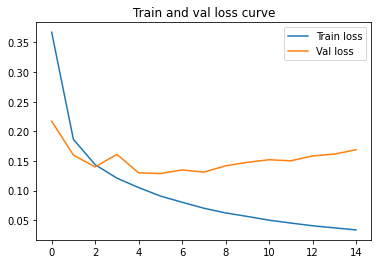

In [ ]:
import matplotlib.pyplot as plt
plt.title("Train and val loss curve")
plt.plot(range(15), train_loss_list, label='Train loss')
plt.plot(range(15), val_loss_list, label='Val loss')
plt.legend()
plt.show()

### 5.4 Evaluation

In [ ]:
# Testing
test_loss = 0
test_acc = 0
model.eval()

predictions , true_labels = [], []

used_size = 10
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                              attention_mask=b_input_mask, labels=b_labels)
        logits = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.append(label_ids)
    
    tmp_eval_accuracy = accuracy(logits, label_ids)
    
    test_loss += tmp_eval_loss.mean().item()
    test_acc += tmp_eval_accuracy
    
pred_tags = [tag_ids[p_i] for p in predictions for p_i in p]
valid_tags = [tag_ids[l_ii] for l in true_labels for l_i in l for l_ii in l_i]

test_loss = test_loss/len(test_dataloader)
test_acc = test_acc/len(test_dataloader)

print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

	Test Loss: 0.169 | Test Acc: 92.40%


In [ ]:
from sklearn.metrics import classification_report

# Convert the index to tag
pred_tag = []
for row in pred_tags:
  for i in row:
    pred_tag.append(idx2tag[i])

y_te_true_tag = []
for row in valid_tags:
  for i in row:
    y_te_true_tag.append(idx2tag[i])

report = classification_report(pred_tag, y_te_true_tag)
print(report)

              precision    recall  f1-score   support

       B-geo       0.81      0.35      0.49     75381
       B-gpe       0.77      0.37      0.50     34997
       B-org       0.73      0.29      0.42     26858
       B-per       0.81      0.37      0.51     48331
       B-tim       0.80      0.33      0.47     42352
       I-geo       0.74      0.29      0.41     17407
       I-org       0.69      0.35      0.46      6596
       I-per       0.82      0.37      0.51     33916
           O       1.00      1.00      1.00  53669162

    accuracy                           1.00  53955000
   macro avg       0.80      0.41      0.53  53955000
weighted avg       1.00      1.00      1.00  53955000



In [ ]:
i = np.random.randint(0, X_te.shape[0]) # choose a random number between 0 and len(X_te)
predictions = [idx2tag[idx] for idx in pred_tags[i]]
true = [idx2tag[idx] for idx in valid_tags[i]]

print("Sample number {} of {} (Test Set)".format(i, X_te.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, predictions):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], t, pred))

Sample number 2529 of 9592 (Test Set)
Word           ||True ||Pred
It             : O     O
also           : O     O
extends        : O     O
the            : O     O
detention      : O     O
period         : O     O
for            : O     O
terrorism      : O     O
suspects       : O     O
from           : O     O
four           : O     O
to             : O     O
up             : O     O
to             : O     O
six            : O     O
days           : O     O
.              : O     O


### 5.5 Save Model

In [ ]:
model_save_name = 'Bert_model_weights.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

# 6. Bert model without pretrained weights

### 6.1 Data preprocessing

In [ ]:
#pretrained tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in word_sent]

# tokenized text to id as input for later
word_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# tags to id as input for later
tag_ids = pad_sequences([[tag2idx.get(l) for l in lab] for lab in tag_sent],
                     maxlen=MAX_LEN, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [ ]:

attention_masks = [[float(i>0) for i in ii] for ii in word_ids]

tr_inputs, test_inputs, tr_tags, test_tags = train_test_split(word_ids, tag_ids, 
                                                            random_state=233, test_size=0.2)
tr_masks, test_masks= train_test_split(attention_masks, random_state=233, test_size=0.2)

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(tr_inputs, tr_tags, 
                                                            random_state=233, test_size=0.2)
tr_masks, val_masks = train_test_split(tr_masks, random_state=233, test_size=0.2)


tr_inputs = torch.tensor(tr_inputs)
tr_tags = torch.tensor(tr_tags)
tr_masks = torch.tensor(tr_masks)
test_inputs = torch.tensor(test_inputs)
test_tags = torch.tensor(test_tags)
test_masks = torch.tensor(test_masks)
val_inputs = torch.tensor(val_inputs)
val_tags = torch.tensor(val_tags)
val_masks = torch.tensor(val_masks)

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)


### 6.2 Model initialization

In [ ]:
config = BertConfig(vocab_size_or_config_json_file= 30522, num_hidden_layers=3)
model = BertForTokenClassification(config=config, num_labels=len(tag2idx))
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
      

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01}
         ,
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [ ]:
def accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Main training loop 
epochs = 15
max_grad_norm = 1.0
best_valid_loss = float('inf')
train_loss_list = []
val_loss_list = []


for _ in trange(epochs, desc="Epoch"):
    model.train()
    tr_loss = 0
    # traing on batch 
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        
        
        # backward pass
        loss.backward()

        # track train loss
        tr_loss += loss.item()

        # gradient clipping to prevent exploding gradients in very deep networks
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)

        # update parameters to take one gradient step
        optimizer.step()
        model.zero_grad()
   
    # VALIDATION on validation batch set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        # batch = tuple(t for t in batch)
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
    pred_tags = [[p_i for p_i in p] for p in predictions ]
    valid_tags = [l_i for l in true_labels for l_i in l]

    if eval_loss < best_valid_loss:
        best_valid_loss = eval_loss
        model_save_name = 'Bert_non-pretrained_model_weights.pth'
        path = F"/content/gdrive/My Drive/{model_save_name}" 
        torch.save(model, path)

    # print loss/accuracy per epoch
    train_loss=tr_loss/ len(train_dataloader)
    eval_loss = eval_loss/len(valid_dataloader)
    eval_acc=eval_accuracy/len(valid_dataloader)

    train_loss_list.append(train_loss)
    val_loss_list.append(eval_loss)

    print("Epoch: " + str(_))
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {eval_loss:.3f} |  Val. Acc: {eval_acc*100:.2f}%')

Epoch:   7%|▋         | 1/15 [01:19<18:34, 79.64s/it]

Epoch: 0
	Train Loss: 0.559
	 Val. Loss: 0.474 |  Val. Acc: 96.35%


Epoch:  13%|█▎        | 2/15 [02:38<17:10, 79.30s/it]

Epoch: 1
	Train Loss: 0.435
	 Val. Loss: 0.389 |  Val. Acc: 96.57%


Epoch:  20%|██        | 3/15 [03:57<15:51, 79.26s/it]

Epoch: 2
	Train Loss: 0.355
	 Val. Loss: 0.334 |  Val. Acc: 96.54%


Epoch:  27%|██▋       | 4/15 [05:16<14:30, 79.16s/it]

Epoch: 3
	Train Loss: 0.303
	 Val. Loss: 0.308 |  Val. Acc: 95.26%


Epoch:  33%|███▎      | 5/15 [06:35<13:11, 79.12s/it]

Epoch: 4
	Train Loss: 0.266
	 Val. Loss: 0.286 |  Val. Acc: 95.64%


Epoch:  40%|████      | 6/15 [07:55<11:52, 79.17s/it]

Epoch: 5
	Train Loss: 0.237
	 Val. Loss: 0.274 |  Val. Acc: 95.29%


Epoch:  47%|████▋     | 7/15 [09:14<10:33, 79.16s/it]

Epoch: 6
	Train Loss: 0.214
	 Val. Loss: 0.267 |  Val. Acc: 94.61%


Epoch:  53%|█████▎    | 8/15 [10:33<09:13, 79.12s/it]

Epoch: 7
	Train Loss: 0.193
	 Val. Loss: 0.265 |  Val. Acc: 93.85%


Epoch:  60%|██████    | 9/15 [11:52<07:55, 79.18s/it]

Epoch: 8
	Train Loss: 0.175
	 Val. Loss: 0.259 |  Val. Acc: 95.33%


Epoch:  67%|██████▋   | 10/15 [13:11<06:35, 79.01s/it]

Epoch: 9
	Train Loss: 0.161
	 Val. Loss: 0.262 |  Val. Acc: 94.59%


Epoch:  73%|███████▎  | 11/15 [14:29<05:15, 78.82s/it]

Epoch: 10
	Train Loss: 0.148
	 Val. Loss: 0.263 |  Val. Acc: 94.15%


Epoch:  80%|████████  | 12/15 [15:48<03:56, 78.69s/it]

Epoch: 11
	Train Loss: 0.136
	 Val. Loss: 0.266 |  Val. Acc: 94.08%


Epoch:  87%|████████▋ | 13/15 [17:06<02:37, 78.61s/it]

Epoch: 12
	Train Loss: 0.124
	 Val. Loss: 0.269 |  Val. Acc: 94.76%


Epoch:  93%|█████████▎| 14/15 [18:24<01:18, 78.54s/it]

Epoch: 13
	Train Loss: 0.115
	 Val. Loss: 0.275 |  Val. Acc: 95.37%


Epoch: 100%|██████████| 15/15 [19:43<00:00, 78.89s/it]

Epoch: 14
	Train Loss: 0.106
	 Val. Loss: 0.281 |  Val. Acc: 95.08%


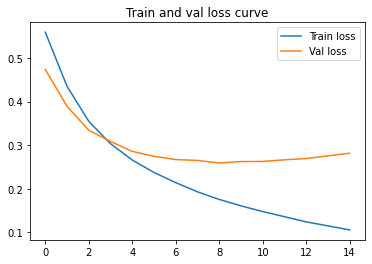

In [ ]:
import matplotlib.pyplot as plt
plt.title("Train and val loss curve")
plt.plot(range(15), train_loss_list, label='Train loss')
plt.plot(range(15), val_loss_list, label='Val loss')
plt.legend()
plt.show()

### 6.4 Evaluation

In [ ]:
# Testing
test_loss = 0
test_acc = 0
model.eval()

predictions , true_labels = [], []

used_size = 10
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                              attention_mask=b_input_mask, labels=b_labels)
        logits = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.append(label_ids)
    
    tmp_eval_accuracy = accuracy(logits, label_ids)
    
    test_loss += tmp_eval_loss.mean().item()
    test_acc += tmp_eval_accuracy
    
  
pred_tags = [[p_i for p_i in p] for p in predictions ]
valid_tags = [l_i for l in true_labels for l_i in l]

test_loss = test_loss/len(test_dataloader)
test_acc = test_acc/len(test_dataloader)

print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

	Test Loss: 0.276 | Test Acc: 95.11%


In [ ]:
from sklearn.metrics import classification_report

# Convert the index to tag
y_te_true_tag = []
for row in valid_tags:
  for i in row:
    y_te_true_tag.append(idx2tag[i])
    
pred_tag = []
for row in pred_tags:
  for i in row:
    pred_tag.append(idx2tag[i])


report = classification_report(pred_tag, y_te_true_tag)
print(report)

              precision    recall  f1-score   support

       B-art       0.12      0.41      0.18        22
       B-eve       0.17      0.34      0.23        32
       B-geo       0.61      0.46      0.52      9968
       B-gpe       0.77      0.28      0.41      8533
       B-nat       0.24      0.48      0.32        23
       B-org       0.55      0.30      0.39      7267
       B-per       0.68      0.61      0.64      3752
       B-tim       0.64      0.49      0.55      5305
       I-art       0.00      0.00      0.00        12
       I-eve       0.16      0.60      0.25        15
       I-geo       0.52      0.44      0.48      1743
       I-gpe       0.30      0.81      0.44        16
       I-nat       0.12      0.33      0.18         3
       I-org       0.51      0.43      0.47      3941
       I-per       0.75      0.61      0.67      4230
       I-tim       0.48      0.32      0.38      1909
           O       0.97      0.99      0.98    672629

    accuracy              

In [ ]:
i = np.random.randint(0, X_te.shape[0]) # choose a random number between 0 and len(X_te)

predictions = [idx2tag[idx] for idx in pred_tags[i]]
true = [idx2tag[idx] for idx in valid_tags[i]]

print("Sample number {} of {} (Test Set)".format(i, X_te.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, predictions):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], t, pred))

Sample number 7838 of 9592 (Test Set)
Word           ||True ||Pred
Afghan         : O     O
officials      : O     O
say            : O     O
at             : O     O
least          : B-geo B-geo
27             : O     O
people         : O     O
were           : B-geo B-geo
killed         : O     B-tim
when           : B-tim B-tim
a              : I-tim O
suicide        : O     O
bomber         : O     B-geo
detonated      : B-geo B-geo
explosives     : O     O
in             : B-per O
a              : I-per O
crowded        : O     O
area           : O     O
in             : B-gpe B-gpe
southern       : O     O
Helmand        : O     O
province       : O     O
.              : O     O


In [ ]:
model_save_name = 'Bert_without_pretrained_model_weights.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)